In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import polars as pl
import fastai.vision.all as fv
import numpy as np
import torch

# Enable TFloat
torch.set_float32_matmul_precision('high')

from torch.utils.data import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

from einops.layers.torch import Rearrange, Reduce
from einops import rearrange
from torchvision.ops import Permute
import torch.nn.functional as F
from typing import Callable, Optional
from torch import nn, Tensor
from torch.nn import functional as F
from functools import partial

from arch import Net

/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#test_df = pl.read_csv('/mnt/ssd/kaggle/test.csv')
weightings = pd.read_csv('/mnt/ssd/kaggle/sample_submission.csv', nrows=1)
#train_df = pl.read_csv('/mnt/ssd/kaggle/train.csv', n_rows=1_000_000, n_threads=10) # dtypes=[pl.datatypes.String] + [pl.Float32]*924

In [4]:
weights = weightings.iloc[0, 1:].values.astype(np.float64)

In [5]:
#train_df.write_parquet('/mnt/ssd/kaggle/train3.parquet')
#test_df.write_parquet('/mnt/ssd/kaggle/test.parquet')
#test_df = pl.read_parquet('/mnt/ssd/kaggle/test.parquet')
train_df = pl.read_parquet('/mnt/ssd/kaggle/train2.parquet')

In [162]:
pl.Config(tbl_cols=-1)

FEAT_COLS = train_df.columns[1:557-60*3]
TARGET_COLS= train_df.columns[557:]

NUM_VERT = 60
NUM_VERT_FEAT = 6
NUM_VERT_FEAT_Y = 6



FEAT_COLS = train_df.columns[1:557-60*3]
TARGET_COLS= train_df.columns[557:]


NUM_2D_FEAT = len(FEAT_COLS) - NUM_VERT*NUM_VERT_FEAT
NUM_2D_FEAT_Y = len(TARGET_COLS) - NUM_VERT*NUM_VERT_FEAT_Y

# Predict a multiplier of q for q_tends
FRAC_IDXS = (NUM_VERT, NUM_VERT*4)

NUM_2D_FEAT, NUM_2D_FEAT_Y

(16, 8)

In [11]:
FEAT_COLS[-NUM_2D_FEAT:], TARGET_COLS[-NUM_2D_FEAT_Y:]

(['state_ps',
  'pbuf_SOLIN',
  'pbuf_LHFLX',
  'pbuf_SHFLX',
  'pbuf_TAUX',
  'pbuf_TAUY',
  'pbuf_COSZRS',
  'cam_in_ALDIF',
  'cam_in_ALDIR',
  'cam_in_ASDIF',
  'cam_in_ASDIR',
  'cam_in_LWUP',
  'cam_in_ICEFRAC',
  'cam_in_LANDFRAC',
  'cam_in_OCNFRAC',
  'cam_in_SNOWHLAND'],
 ['cam_out_NETSW',
  'cam_out_FLWDS',
  'cam_out_PRECSC',
  'cam_out_PRECC',
  'cam_out_SOLS',
  'cam_out_SOLL',
  'cam_out_SOLSD',
  'cam_out_SOLLD'])

In [12]:
x_train = train_df.select(FEAT_COLS).to_numpy()
y_train = train_df.select(TARGET_COLS).to_numpy()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=42)

In [13]:
#x_test = test_df.select(FEAT_COLS).to_numpy()

In [14]:
# import gc
# del train_df
# gc.collect()

In [15]:
train_df.select(TARGET_COLS).std()

ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,ptend_t_36,ptend_t_37,ptend_t_38,ptend_t_39,ptend_t_40,ptend_t_41,ptend_t_42,ptend_t_43,ptend_t_44,ptend_t_45,ptend_t_46,ptend_t_47,ptend_t_48,ptend_t_49,ptend_t_50,ptend_t_51,ptend_t_52,ptend_t_53,ptend_t_54,ptend_t_55,ptend_t_56,ptend_t_57,ptend_t_58,ptend_t_59,ptend_q0001_0,ptend_q0001_1,ptend_q0001_2,ptend_q0001_3,ptend_q0001_4,ptend_q0001_5,ptend_q0001_6,ptend_q0001_7,ptend_q0001_8,ptend_q0001_9,ptend_q0001_10,ptend_q0001_11,ptend_q0001_12,ptend_q0001_13,ptend_q0001_14,ptend_q0001_15,ptend_q0001_16,ptend_q0001_17,ptend_q0001_18,ptend_q0001_19,ptend_q0001_20,ptend_q0001_21,ptend_q0001_22,ptend_q0001_23,ptend_q0001_24,ptend_q0001_25,ptend_q0001_26,ptend_q0001_27,ptend_q0001_28,ptend_q0001_29,ptend_q0001_30,ptend_q0001_31,ptend_q0001_32,ptend_q0001_33,ptend_q0001_34,ptend_q0001_35,ptend_q0001_36,ptend_q0001_37,ptend_q0001_38,ptend_q0001_39,ptend_q0001_40,ptend_q0001_41,ptend_q0001_42,ptend_q0001_43,ptend_q0001_44,ptend_q0001_45,ptend_q0001_46,ptend_q0001_47,ptend_q0001_48,ptend_q0001_49,ptend_q0001_50,ptend_q0001_51,ptend_q0001_52,ptend_q0001_53,ptend_q0001_54,ptend_q0001_55,ptend_q0001_56,ptend_q0001_57,ptend_q0001_58,ptend_q0001_59,ptend_q0002_0,ptend_q0002_1,ptend_q0002_2,ptend_q0002_3,ptend_q0002_4,ptend_q0002_5,ptend_q0002_6,ptend_q0002_7,ptend_q0002_8,ptend_q0002_9,ptend_q0002_10,ptend_q0002_11,ptend_q0002_12,ptend_q0002_13,ptend_q0002_14,ptend_q0002_15,ptend_q0002_16,ptend_q0002_17,ptend_q0002_18,ptend_q0002_19,ptend_q0002_20,ptend_q0002_21,ptend_q0002_22,ptend_q0002_23,ptend_q0002_24,ptend_q0002_25,ptend_q0002_26,ptend_q0002_27,ptend_q0002_28,ptend_q0002_29,ptend_q0002_30,ptend_q0002_31,ptend_q0002_32,ptend_q0002_33,ptend_q0002_34,ptend_q0002_35,ptend_q0002_36,ptend_q0002_37,ptend_q0002_38,ptend_q0002_39,ptend_q0002_40,ptend_q0002_41,ptend_q0002_42,ptend_q0002_43,ptend_q0002_44,ptend_q0002_45,ptend_q0002_46,ptend_q0002_47,ptend_q0002_48,ptend_q0002_49,ptend_q0002_50,ptend_q0002_51,ptend_q0002_52,ptend_q0002_53,ptend_q0002_54,ptend_q0002_55,ptend_q0002_56,ptend_q0002_57,ptend_q0002_58,ptend_q0002_59,ptend_q0003_0,ptend_q0003_1,ptend_q0003_2,ptend_q0003_3,ptend_q0003_4,ptend_q0003_5,ptend_q0003_6,ptend_q0003_7,ptend_q0003_8,ptend_q0003_9,ptend_q0003_10,ptend_q0003_11,ptend_q0003_12,ptend_q0003_13,ptend_q0003_14,ptend_q0003_15,ptend_q0003_16,ptend_q0003_17,ptend_q0003_18,ptend_q0003_19,ptend_q0003_20,ptend_q0003_21,ptend_q0003_22,ptend_q0003_23,ptend_q0003_24,ptend_q0003_25,ptend_q0003_26,ptend_q0003_27,ptend_q0003_28,ptend_q0003_29,ptend_q0003_30,ptend_q0003_31,ptend_q0003_32,ptend_q0003_33,ptend_q0003_34,ptend_q0003_35,ptend_q0003_36,ptend_q0003_37,ptend_q0003_38,ptend_q0003_39,ptend_q0003_40,ptend_q0003_41,ptend_q0003_42,ptend_q0003_43,ptend_q0003_44,ptend_q0003_45,ptend_q0003_46,ptend_q0003_47,ptend_q0003_48,ptend_q0003_49,ptend_q0003_50,ptend_q0003_51,ptend_q0003_52,ptend_q0003_53,ptend_q0003_54,ptend_q0003_55,ptend_q0003_56,ptend_q0003_57,ptend_q0003_58,ptend_q0003_59,ptend_u_0,ptend_u_1,ptend_u_2,ptend_u_3,ptend_u_4,ptend_u_5,ptend_u_6,ptend_u_7,ptend_u_8,ptend_u_9,ptend_u_10,ptend_u_11,ptend_u_12,ptend_u_13,ptend_u_14,ptend_u_15,ptend_u_16,ptend_u_17,ptend_u_18,ptend_u_19,ptend_u_20,ptend_u_21,ptend_u_22,ptend_u_23,ptend_u_24,ptend_u_25,ptend_u_26,ptend_u_27,ptend_u_28,ptend_u_29,ptend_u_30,ptend_u_31,ptend_u_32,ptend_u_33,ptend_u_34,ptend_u_35,ptend_u_36,ptend_u_37,ptend_u_38,ptend_u_39,ptend_u_40,ptend_u_41,ptend_u_42,ptend_u_43,ptend_u_44,ptend_u_45,ptend_u_46,ptend_u_47,ptend_u_48,ptend_u_49,ptend_u_50,ptend_u_51,ptend_u_52,ptend_u_53,ptend_u_54,ptend_u_55,ptend_u_56,ptend_u_57,ptend_u_58,ptend_u_59,ptend_v_0,ptend_v_1,ptend_v_2,

In [16]:
std_weights = 1.0/(weights)
std_weights[weights == 0] = 0
assert np.isfinite(std_weights).all()

/tmp/ipykernel_376574/2352397551.py:1: RuntimeWarning: divide by zero encountered in divide
  std_weights = 1.0/(weights)


In [17]:
1/weights.max()

1e-15

In [209]:
import json

class Norm():
    def __init__(self, fname=None, stds=None, means=None, zero_mask=None, dataset=None, eps=1e-14):
        if dataset is not None:        
            self.means, self.stds = np.mean(dataset, axis=0), np.std(dataset, axis=0)
            with open(fname, 'w') as f:
                f.write(json.dumps({'means' : self.means.tolist(), 'stds' : self.stds.tolist()}))
        elif means is not None and stds is not None:
            self.stds = stds.copy()
            self.means = means.copy()
        else:
            with open(fname) as f:
                stats_dict = json.loads(f.read())
                
            self.means = np.asarray(stats_dict['means'])
            self.stds = np.asarray(stats_dict['stds'])
            
        self.means = self.means[None, :]
        self.stds = self.stds[None, :]

        self.zero_mask = self.stds[0] <= eps if zero_mask is None else zero_mask
         
        self.stds[:, self.zero_mask] = 1.0
        
        self.eps = eps
        #self.df = pd.DataFrame({'col' : names, 'std' : self.stds, 'mean' : self.means})
        
    def __call__(self, data):
        out = (data - self.means) / self.stds
        out[:, self.zero_mask] = 0
        
        return out.astype(np.float32)
        
    def denorm(self, data):
        data = data.astype(np.float64)
        out = data * self.stds + self.means 
        
        out[:, self.zero_mask] = 0#self.means[:, self.zero_mask]
        return out


In [210]:
norm_x = Norm(fname='x_stats6.json', eps=1e-7) # dataset=x_train)
# Set means to zero for q vars so we can predict a multipler
norm_x.means[:, FRAC_IDXS[0]:FRAC_IDXS[1]] = 0.0
norm_y = Norm(stds=std_weights, means=np.zeros_like(std_weights))# dataset=y_train)

In [211]:
# This variable still seems to have norm issues.
indx = TARGET_COLS.index('ptend_q0002_26')
col = "ptend_q0002_26"
norm_y.zero_mask[indx] = True


In [212]:
norm_y.zero_mask[indx-1:indx+2]

array([ True,  True, False])

In [213]:
norm_x.zero_mask.sum(), norm_x.zero_mask

(55,
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True,  True,  True,  True,  True,
 

In [214]:
# y_t = norm_y(y_train[0:1000])

In [215]:
# pred_norm = norm_x(x_train[0:1000])

In [216]:
# pred_norm.max(), pred_norm.std()

In [217]:
# pred = norm_y.denorm(y_t)

In [218]:
# (y_train[0:1000] - pred).max()

In [219]:
class Loader(Dataset):
    def __init__(self, data_dict, norm_dict):
        self.data_dict = data_dict
        self.norm_dict = norm_dict
        
    def __getitem__(self, idx):
        x = self.data_dict['x'][idx].copy()
        y = self.data_dict['y'][idx].copy() if 'y' in self.data_dict else np.zeros(1)
        x = self.norm_dict['x'](x[None, :])[0]
        y = self.norm_dict['y'](y[None, :])[0] if 'y' in self.data_dict else np.zeros(1)
        return x.astype(np.float32), y.astype(np.float32)
    
    def __len__(self,):
        return self.data_dict['x'].shape[0]

In [220]:
train_ds = Loader({'x' : x_train, 'y' : y_train}, {'x' : norm_x, 'y' : norm_y})
val_ds = Loader({'x' : x_val, 'y' : y_val}, {'x' : norm_x, 'y' : norm_y})

In [221]:
len(train_ds), len(val_ds), #len(x_test)

(3800000, 200000)

In [222]:
from random import shuffle


bs = 128
train_loader = fv.DataLoader(train_ds, batch_size=bs, drop_last=True, 
                          shuffle=True, num_workers=0, pin_memory=False)
valid_loader = fv.DataLoader(val_ds, batch_size=bs, drop_last=True,
                             shuffle=False, num_workers=0, pin_memory=False)


In [223]:
batch = next(iter(train_loader))
batch[0].mean(), batch[0].std(), batch[1].mean(), batch[1].std(), batch[0].min(), batch[0].max(), batch[1].min(), batch[1].max()

(tensor(0.3047),
 tensor(1.1348),
 tensor(-0.0071),
 tensor(0.8889),
 tensor(-5.8833),
 tensor(12.1511),
 tensor(-20.6266),
 tensor(20.0354))

In [224]:
batch[0][:, FRAC_IDXS[0]:FRAC_IDXS[1]].mean(dim=0)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0871e+00,
        5.1212e+00, 3.8043e+00, 2.9061e+00, 2.4356e+00, 2.7418e+00, 2.5049e+00,
        2.0905e+00, 1.7764e+00, 1.7255e+00, 1.6798e+00, 1.3521e+00, 1.0898e+00,
        9.2466e-01, 8.1743e-01, 7.6408e-01, 7.3616e-01, 7.2304e-01, 7.2968e-01,
        7.5194e-01, 7.7596e-01, 8.0562e-01, 8.3858e-01, 8.8277e-01, 9.3555e-01,
        9.9017e-01, 1.0570e+00, 1.1224e+00, 1.1815e+00, 1.2329e+00, 1.2899e+00,
        1.3437e+00, 1.3864e+00, 1.4293e+00, 1.4707e+00, 1.5071e+00, 1.5322e+00,
        1.5537e+00, 1.5726e+00, 1.5947e+00, 1.6145e+00, 1.6256e+00, 1.6332e+00,
        1.6289e+00, 1.6202e+00, 1.6100e+00, 1.6042e+00, 1.6049e+00, 1.6080e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [32]:
batch[0].shape, batch[1].shape

(torch.Size([128, 376]), torch.Size([128, 368]))

In [60]:
batch[1].min()

tensor(-19.1092)

In [225]:
#net = torch.compile(net)
dls = fv.DataLoaders(train_loader, valid_loader).to('cuda')

In [188]:
net = Net(NUM_2D_FEAT, NUM_VERT_FEAT, NUM_2D_FEAT_Y, NUM_VERT_FEAT_Y, frac_idxs=FRAC_IDXS)
#net(batch[0])

In [226]:
def l1_loss(pred, tar):
    diff = torch.abs(tar - pred)
    return diff.mean()

In [227]:
def mse(pred, tar):
    diff = tar - pred
    return ((diff)**2).mean()

def r_squared(pred, tar, mask=None):
    #tar = norm_y.denorm(tar.cpu().numpy())
    #pred = norm_y.denorm(pred.detach().cpu().numpy())
    #pred = pred*weights[None, :]
    #tar = tar*weights[None, :]
    if mask is not None:
        tar = tar[:, mask]
        pred = pred[:, mask]
    
    return 1 - (torch.sum((tar - pred)**2) / torch.sum((tar - tar.mean())**2))
    

In [237]:
learn = fv.Learner(dls, net, loss_func=nn.HuberLoss(delta=10.0), metrics=[fv.mae, fv.mse, r_squared],
                   wd=0.001, opt_func=fv.ranger, cbs=[fv.SaveModelCallback(monitor='r_squared', comp=np.greater), fv.GradientClip(1.0)])

In [229]:
learn.summary()

Net (Input shape: 128 x 376)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 960 x 1       
Conv1d                                    1920       True      
____________________________________________________________________________
                     128 x 16 x 60       
Rearrange                                                      
____________________________________________________________________________
                     128 x 6 x 60        
Rearrange                                                      
____________________________________________________________________________
                     128 x 240 x 60      
Conv1d                                    480        True      
Conv1d                                    2048       True      
LayerNorm                                 512        True      
____________________________________________________________________________
                     128 x 60 x 1024     
Linea

SuggestedLRs(valley=0.0003311311302240938)

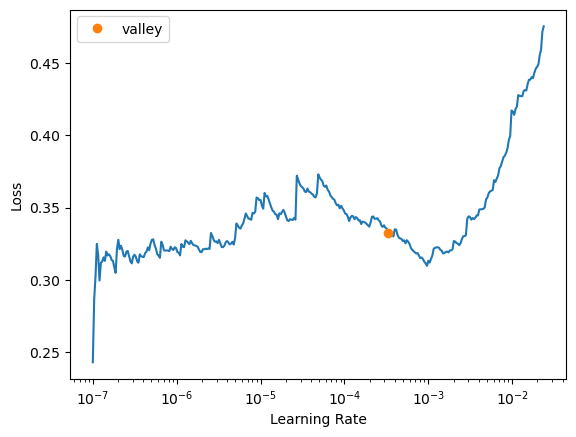

In [230]:
learn.lr_find(num_it=500)

In [ ]:
learn.fit_flat_cos(15, 1e-3, pct_start=0.5)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.123545,0.125531,0.169564,0.307329,0.692488,19:50


Better model found at epoch 0 with r_squared value: 0.6924877762794495.


In [ ]:
165/(198*1e4)

In [88]:
learn.fit_flat_cos(15, 4e-4, pct_start=0.5)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.229272,0.260041,0.152555,0.260041,0.727625,27:52
1,0.210327,0.256274,0.153173,0.256274,0.729453,27:53
2,0.210848,0.252755,0.153384,0.252755,0.729167,27:57
3,0.369781,0.252151,0.153907,0.252151,0.728009,27:55
4,0.190333,0.252129,0.154275,0.252129,0.725401,27:54
5,0.194347,0.253543,0.154800,0.253543,0.723863,27:55
6,0.188494,0.256584,0.155276,0.256584,0.719586,27:55
7,0.184154,0.256038,0.155658,0.256038,0.719379,27:54
8,0.178666,0.258872,0.156046,0.258872,0.715114,27:56
9,0.168267,0.257935,0.155296,0.257935,0.716201,27:51


Better model found at epoch 0 with valid_loss value: 0.2600410580635071.
Better model found at epoch 1 with valid_loss value: 0.25627413392066956.
Better model found at epoch 2 with valid_loss value: 0.2527551054954529.
Better model found at epoch 3 with valid_loss value: 0.2521514594554901.
Better model found at epoch 4 with valid_loss value: 0.2521290183067322.


In [73]:
learn.fit_flat_cos(20, 8e-4, pct_start=0.5)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.221799,0.248883,0.161289,0.248883,0.624436,19:30
1,0.216447,0.249240,0.160901,0.249240,0.621538,19:30
2,0.211245,0.249448,0.160596,0.249448,0.617848,19:31
3,0.221787,0.248711,0.160692,0.248711,0.620983,19:34
4,0.214866,0.249098,0.160391,0.249098,0.619240,19:35
5,0.212531,0.249636,0.160608,0.249636,0.621107,19:35
6,0.210268,0.251274,0.160549,0.251274,0.621262,19:36
7,0.205438,0.249965,0.160234,0.249965,0.612630,19:33
8,0.211535,0.251200,0.160285,0.251200,0.616812,19:34
9,0.202592,0.250676,0.160388,0.250676,0.620815,19:33


Better model found at epoch 0 with valid_loss value: 0.24888284504413605.
Better model found at epoch 3 with valid_loss value: 0.24871104955673218.


In [71]:
learn.fit_flat_cos(10, 1e-4, pct_start=0.5)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.232228,0.257023,0.163198,0.257023,0.605320,19:34
1,0.241770,0.252950,0.162589,0.252950,0.616660,19:35
2,0.219839,0.249665,0.161875,0.249665,0.611379,19:35
3,0.225076,0.249045,0.161634,0.249045,0.616109,19:35
4,0.211528,0.249282,0.161465,0.249282,0.613677,19:35
5,0.217431,0.248704,0.160870,0.248704,0.610308,19:36
6,0.300959,0.248664,0.160695,0.248664,0.615366,19:36
7,0.219857,0.248102,0.160497,0.248102,0.617658,19:37
8,0.224552,0.248065,0.160396,0.248065,0.619523,19:36
9,0.213481,0.248097,0.160325,0.248097,0.618928,19:36


Better model found at epoch 0 with valid_loss value: 0.2570227384567261.
Better model found at epoch 1 with valid_loss value: 0.2529500126838684.
Better model found at epoch 2 with valid_loss value: 0.2496650665998459.
Better model found at epoch 3 with valid_loss value: 0.24904529750347137.
Better model found at epoch 5 with valid_loss value: 0.24870361387729645.
Better model found at epoch 6 with valid_loss value: 0.2486642599105835.
Better model found at epoch 7 with valid_loss value: 0.248102068901062.
Better model found at epoch 8 with valid_loss value: 0.24806547164916992.


In [74]:
learn.save('good_v3')

Path('models/good_v3.pth')

In [38]:
torch.save(net.state_dict(), 'model_weights_good_v1.pth')

In [34]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.505111813545227.


(#4) [1.6002970933914185,0.505111813545227,1.6571693420410156,0.21333633206727462]

In [ ]:
learn.fit_flat_cos(20, 1e-3)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.326428,0.325009,0.234470,0.355308,0.493184,25:55
1,0.266216,0.291889,0.213740,0.315320,0.501836,26:59
2,0.262931,0.283098,0.208533,0.304048,0.549058,27:01
3,0.256095,0.275646,0.202871,0.295436,0.575205,27:07


[2024-04-25 23:31:58,521] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/tmp/ipykernel_23299/3148654658.py:112)
   reasons:  ___check_obj_id(self, 140033784157216)
to diagnose recompilation issues, see https://pytorch.org/docs/master/dynamo/troubleshooting.html.


Better model found at epoch 0 with valid_loss value: 0.32500866055488586.


[2024-04-25 23:32:20,991] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/home/leroy/conda/envs/torch2/lib/python3.10/site-packages/torchvision/ops/misc.py:319)
   reasons:  ___check_obj_id(self, 140033784156448)
to diagnose recompilation issues, see https://pytorch.org/docs/master/dynamo/troubleshooting.html.


Better model found at epoch 1 with valid_loss value: 0.2918890714645386.
Better model found at epoch 2 with valid_loss value: 0.28309792280197144.
Better model found at epoch 3 with valid_loss value: 0.2756464183330536.


In [56]:
learn.fit_flat_cos(6, 1e-3)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.164413,0.165433,0.177333,0.341697,0.417671,07:32
1,0.157905,0.160126,0.169911,0.326655,0.454772,07:15
2,0.156040,0.157170,0.166138,0.316997,0.479607,07:15
3,0.157877,0.155061,0.163412,0.310182,0.490179,07:16
4,0.153847,0.151915,0.159921,0.296685,0.539397,07:16
5,0.145465,0.145779,0.153717,0.277628,0.580840,07:15


In [82]:
learn.fit_flat_cos(6, 7e-3)

epoch,train_loss,valid_loss,mae,mse,r_squared,time
0,0.196049,0.195223,0.172460,0.320301,0.470430,07:29


In [59]:
learn.save('res_conv_v1')

Path('models/res_conv_v1.pth')

In [81]:
learn.fit_flat_cos(5, 3e-3)

epoch,train_loss,valid_loss,mae,mse,r_squared,time


KeyboardInterrupt: 

In [90]:
test_df = pl.read_parquet('/mnt/ssd/kaggle/test.parquet')

In [91]:
#test_df = pl.read_csv('/mnt/ssd/kaggle/test.csv')

x_test = test_df.select(FEAT_COLS).to_numpy()

test_ds = Loader({'x' : x_test}, {'x' : norm_x})
test_loader = fv.DataLoader(test_ds, batch_size=bs, drop_last=False, shuffle=False, 
                            num_workers=0, pin_memory=True)

In [92]:
test_df

sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,state_t_10,state_t_11,state_t_12,state_t_13,state_t_14,state_t_15,state_t_16,state_t_17,state_t_18,state_t_19,state_t_20,state_t_21,state_t_22,state_t_23,state_t_24,state_t_25,state_t_26,state_t_27,state_t_28,state_t_29,state_t_30,state_t_31,state_t_32,state_t_33,state_t_34,state_t_35,state_t_36,state_t_37,state_t_38,state_t_39,state_t_40,state_t_41,state_t_42,state_t_43,state_t_44,state_t_45,state_t_46,state_t_47,state_t_48,state_t_49,state_t_50,state_t_51,state_t_52,state_t_53,state_t_54,state_t_55,state_t_56,state_t_57,state_t_58,state_t_59,state_q0001_0,state_q0001_1,state_q0001_2,state_q0001_3,state_q0001_4,state_q0001_5,state_q0001_6,state_q0001_7,state_q0001_8,state_q0001_9,state_q0001_10,state_q0001_11,state_q0001_12,state_q0001_13,state_q0001_14,state_q0001_15,state_q0001_16,state_q0001_17,state_q0001_18,state_q0001_19,state_q0001_20,state_q0001_21,state_q0001_22,state_q0001_23,state_q0001_24,state_q0001_25,state_q0001_26,state_q0001_27,state_q0001_28,state_q0001_29,state_q0001_30,state_q0001_31,state_q0001_32,state_q0001_33,state_q0001_34,state_q0001_35,state_q0001_36,state_q0001_37,state_q0001_38,state_q0001_39,state_q0001_40,state_q0001_41,state_q0001_42,state_q0001_43,state_q0001_44,state_q0001_45,state_q0001_46,state_q0001_47,state_q0001_48,state_q0001_49,state_q0001_50,state_q0001_51,state_q0001_52,state_q0001_53,state_q0001_54,state_q0001_55,state_q0001_56,state_q0001_57,state_q0001_58,state_q0001_59,state_q0002_0,state_q0002_1,state_q0002_2,state_q0002_3,state_q0002_4,state_q0002_5,state_q0002_6,state_q0002_7,state_q0002_8,state_q0002_9,state_q0002_10,state_q0002_11,state_q0002_12,state_q0002_13,state_q0002_14,state_q0002_15,state_q0002_16,state_q0002_17,state_q0002_18,state_q0002_19,state_q0002_20,state_q0002_21,state_q0002_22,state_q0002_23,state_q0002_24,state_q0002_25,state_q0002_26,state_q0002_27,state_q0002_28,state_q0002_29,state_q0002_30,state_q0002_31,state_q0002_32,state_q0002_33,state_q0002_34,state_q0002_35,state_q0002_36,state_q0002_37,state_q0002_38,state_q0002_39,state_q0002_40,state_q0002_41,state_q0002_42,state_q0002_43,state_q0002_44,state_q0002_45,state_q0002_46,state_q0002_47,state_q0002_48,state_q0002_49,state_q0002_50,state_q0002_51,state_q0002_52,state_q0002_53,state_q0002_54,state_q0002_55,state_q0002_56,state_q0002_57,state_q0002_58,state_q0002_59,state_q0003_0,state_q0003_1,state_q0003_2,state_q0003_3,state_q0003_4,state_q0003_5,state_q0003_6,state_q0003_7,state_q0003_8,state_q0003_9,state_q0003_10,state_q0003_11,state_q0003_12,state_q0003_13,state_q0003_14,state_q0003_15,state_q0003_16,state_q0003_17,state_q0003_18,state_q0003_19,state_q0003_20,state_q0003_21,state_q0003_22,state_q0003_23,state_q0003_24,state_q0003_25,state_q0003_26,state_q0003_27,state_q0003_28,state_q0003_29,state_q0003_30,state_q0003_31,state_q0003_32,state_q0003_33,state_q0003_34,state_q0003_35,state_q0003_36,state_q0003_37,state_q0003_38,state_q0003_39,state_q0003_40,state_q0003_41,state_q0003_42,state_q0003_43,state_q0003_44,state_q0003_45,state_q0003_46,state_q0003_47,state_q0003_48,state_q0003_49,state_q0003_50,state_q0003_51,state_q0003_52,state_q0003_53,state_q0003_54,state_q0003_55,state_q0003_56,state_q0003_57,state_q0003_58,state_q0003_59,state_u_0,state_u_1,state_u_2,state_u_3,state_u_4,state_u_5,state_u_6,state_u_7,state_u_8,state_u_9,state_u_10,state_u_11,state_u_12,state_u_13,state_u_14,state_u_15,state_u_16,state_u_17,state_u_18,state_u_19,state_u_20,state_u_21,state_u_22,state_u_23,state_u_24,state_u_25,state_u_26,state_u_27,state_u_28,state_u_29,state_u_30,state_u_31,state_u_32,state_u_33,state_u_34,state_u_35,state_u_36,state_u_37,state_u_38,state_u_39,state_u_40,state_u_41,state_u_42,state_u_43,state_u_44,state_u_45,state_u_46,state_u_47,state_u_48,state_u_49,state_u_50,state_u_51,state_u_52,state_u_53,state_u_54,state_u_55,state_u_56,state_u_57,state_u_58,state_u_59,state_v_0,state_v_1,

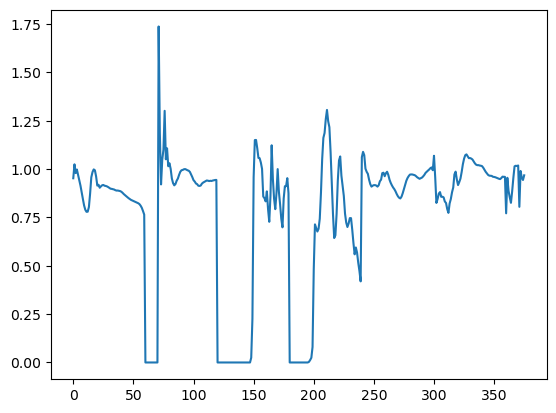

In [93]:
import matplotlib.pyplot as plt

plt.plot(batch[0].std(dim=0).numpy())

In [94]:
x_train[:, 180].mean()

4.9721663e-13

In [95]:
x_test[:, 180].mean()

1.8331273364701616e-11

In [96]:
import tqdm
predictions = []

learn.model.eval()

with torch.no_grad():
    for batch in tqdm.tqdm(test_loader):
        x = batch[0].type(torch.float32)
        pred = learn.model(x.cuda()).cpu().numpy()
        #pred = norm_y.denorm(pred)
        predictions.append(pred)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4883/4883 [01:02<00:00, 78.33it/s]


In [97]:
predicts = np.concatenate(predictions, axis=0)# * weights[None, :]

In [98]:
predicts[0]

array([-2.90352225e-01, -5.37928164e-01, -4.36772108e-01, -6.58519208e-01,
       -8.68134975e-01, -9.40513492e-01, -9.73768950e-01, -1.03008890e+00,
       -1.03226316e+00, -1.00991225e+00, -9.62944269e-01, -9.51476157e-01,
       -9.26043749e-01, -7.41899014e-01, -2.60388315e-01,  2.42894650e-01,
        4.16267604e-01,  4.30659875e-02,  2.86202937e-01, -2.74397135e-02,
       -1.83649957e-01, -3.73298079e-01, -5.30623496e-01, -5.98557115e-01,
       -5.77854514e-01, -5.73151946e-01, -5.91597497e-01, -6.09042943e-01,
       -6.03075624e-01, -6.22090220e-01, -5.99675894e-01, -5.32942295e-01,
       -5.03813982e-01, -4.38010216e-01, -3.95639271e-01, -4.12584335e-01,
       -3.84007424e-01, -3.88512015e-01, -3.99925679e-01, -3.87400985e-01,
       -3.71521205e-01, -3.44047636e-01, -3.76600385e-01, -4.78590727e-01,
       -3.86744827e-01, -4.40060645e-01, -4.24140304e-01, -5.42757571e-01,
       -5.15135348e-01, -4.94252205e-01, -5.99881768e-01, -7.66778767e-01,
       -7.85077572e-01, -

In [99]:
torch.save(predicts, 'preds2.pt')

In [100]:
#predicts = torch.load('preds.pt')

In [94]:
norm_y.zero_mask[60:60*3]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [132]:
output = pl.DataFrame(test_df['sample_id'])

In [133]:
output

sample_id
str
"""test_169651"""
"""test_524862"""
"""test_634129"""
"""test_403572"""
"""test_484578"""
…
"""test_578220"""
"""test_395695"""
"""test_88942"""


In [134]:
indx = TARGET_COLS.index('ptend_q0002_26')
col = "ptend_q0002_26"
norm_y.zero_mask[indx] = True

In [137]:
for n, col in enumerate(TARGET_COLS):
    if norm_y.zero_mask[n]:
        print(f'skipping {col}')
        pl_col = pl.lit(0.0, dtype=pl.Float32).alias(col)
    else:
        pl_col = pl.Series(col, predicts[:, n],  dtype=pl.Float32)
    
    output = output.with_columns(pl_col)
        

skipping ptend_q0001_0
skipping ptend_q0001_1
skipping ptend_q0001_2
skipping ptend_q0001_3
skipping ptend_q0001_4
skipping ptend_q0001_5
skipping ptend_q0001_6
skipping ptend_q0001_7
skipping ptend_q0001_8
skipping ptend_q0001_9
skipping ptend_q0001_10
skipping ptend_q0001_11
skipping ptend_q0002_0
skipping ptend_q0002_1
skipping ptend_q0002_2
skipping ptend_q0002_3
skipping ptend_q0002_4
skipping ptend_q0002_5
skipping ptend_q0002_6
skipping ptend_q0002_7
skipping ptend_q0002_8
skipping ptend_q0002_9
skipping ptend_q0002_10
skipping ptend_q0002_11
skipping ptend_q0002_12
skipping ptend_q0002_13
skipping ptend_q0002_14
skipping ptend_q0002_15
skipping ptend_q0002_16
skipping ptend_q0002_17
skipping ptend_q0002_18
skipping ptend_q0002_19
skipping ptend_q0002_20
skipping ptend_q0002_21
skipping ptend_q0002_22
skipping ptend_q0002_23
skipping ptend_q0002_24
skipping ptend_q0002_25
skipping ptend_q0002_26
skipping ptend_q0003_0
skipping ptend_q0003_1
skipping ptend_q0003_2
skipping ptend_

In [138]:
output.write_csv('submission.csv', )

In [34]:
weights

array([3.09812656e+04, 2.25024316e+04, 1.88941465e+04, 1.45142451e+04,
       1.09443477e+04, 9.06501074e+03, 9.66366895e+03, 1.26885576e+04,
       1.98901719e+04, 2.58313730e+04, 3.38903672e+04, 4.41229414e+04,
       5.98112578e+04, 7.94340781e+04, 1.07358812e+05, 1.35720844e+05,
       1.49399844e+05, 1.28492953e+05, 9.17462344e+04, 7.27487656e+04,
       6.65315391e+04, 6.29323047e+04, 5.66102695e+04, 4.94731445e+04,
       4.30291836e+04, 3.69126758e+04, 3.14869316e+04, 2.68980723e+04,
       2.33166387e+04, 2.04597305e+04, 1.83856836e+04, 1.71114043e+04,
       1.63378096e+04, 1.58577598e+04, 1.55809023e+04, 1.54975908e+04,
       1.56122559e+04, 1.57978848e+04, 1.59742188e+04, 1.61303955e+04,
       1.62613105e+04, 1.63718926e+04, 1.63970195e+04, 1.63254639e+04,
       1.62286406e+04, 1.61918096e+04, 1.63412080e+04, 1.66457109e+04,
       1.70054941e+04, 1.74302988e+04, 1.79072402e+04, 1.84315527e+04,
       1.90324707e+04, 1.97013555e+04, 2.04082363e+04, 2.09672070e+04,
      

In [60]:
gc.collect()

636

In [1]:
predicts = predicts * weights[None, :]

NameError: name 'predicts' is not defined

In [116]:
output.std()

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,ptend_t_36,ptend_t_37,ptend_t_38,ptend_t_39,ptend_t_40,ptend_t_41,ptend_t_42,ptend_t_43,ptend_t_44,ptend_t_45,ptend_t_46,ptend_t_47,ptend_t_48,ptend_t_49,ptend_t_50,ptend_t_51,ptend_t_52,ptend_t_53,ptend_t_54,ptend_t_55,ptend_t_56,ptend_t_57,ptend_t_58,ptend_t_59,ptend_q0001_0,ptend_q0001_1,ptend_q0001_2,ptend_q0001_3,ptend_q0001_4,ptend_q0001_5,ptend_q0001_6,ptend_q0001_7,ptend_q0001_8,ptend_q0001_9,ptend_q0001_10,ptend_q0001_11,ptend_q0001_12,ptend_q0001_13,ptend_q0001_14,ptend_q0001_15,ptend_q0001_16,ptend_q0001_17,ptend_q0001_18,ptend_q0001_19,ptend_q0001_20,ptend_q0001_21,ptend_q0001_22,ptend_q0001_23,ptend_q0001_24,ptend_q0001_25,ptend_q0001_26,ptend_q0001_27,ptend_q0001_28,ptend_q0001_29,ptend_q0001_30,ptend_q0001_31,ptend_q0001_32,ptend_q0001_33,ptend_q0001_34,ptend_q0001_35,ptend_q0001_36,ptend_q0001_37,ptend_q0001_38,ptend_q0001_39,ptend_q0001_40,ptend_q0001_41,ptend_q0001_42,ptend_q0001_43,ptend_q0001_44,ptend_q0001_45,ptend_q0001_46,ptend_q0001_47,ptend_q0001_48,ptend_q0001_49,ptend_q0001_50,ptend_q0001_51,ptend_q0001_52,ptend_q0001_53,ptend_q0001_54,ptend_q0001_55,ptend_q0001_56,ptend_q0001_57,ptend_q0001_58,ptend_q0001_59,ptend_q0002_0,ptend_q0002_1,ptend_q0002_2,ptend_q0002_3,ptend_q0002_4,ptend_q0002_5,ptend_q0002_6,ptend_q0002_7,ptend_q0002_8,ptend_q0002_9,ptend_q0002_10,ptend_q0002_11,ptend_q0002_12,ptend_q0002_13,ptend_q0002_14,ptend_q0002_15,ptend_q0002_16,ptend_q0002_17,ptend_q0002_18,ptend_q0002_19,ptend_q0002_20,ptend_q0002_21,ptend_q0002_22,ptend_q0002_23,ptend_q0002_24,ptend_q0002_25,ptend_q0002_26,ptend_q0002_27,ptend_q0002_28,ptend_q0002_29,ptend_q0002_30,ptend_q0002_31,ptend_q0002_32,ptend_q0002_33,ptend_q0002_34,ptend_q0002_35,ptend_q0002_36,ptend_q0002_37,ptend_q0002_38,ptend_q0002_39,ptend_q0002_40,ptend_q0002_41,ptend_q0002_42,ptend_q0002_43,ptend_q0002_44,ptend_q0002_45,ptend_q0002_46,ptend_q0002_47,ptend_q0002_48,ptend_q0002_49,ptend_q0002_50,ptend_q0002_51,ptend_q0002_52,ptend_q0002_53,ptend_q0002_54,ptend_q0002_55,ptend_q0002_56,ptend_q0002_57,ptend_q0002_58,ptend_q0002_59,ptend_q0003_0,ptend_q0003_1,ptend_q0003_2,ptend_q0003_3,ptend_q0003_4,ptend_q0003_5,ptend_q0003_6,ptend_q0003_7,ptend_q0003_8,ptend_q0003_9,ptend_q0003_10,ptend_q0003_11,ptend_q0003_12,ptend_q0003_13,ptend_q0003_14,ptend_q0003_15,ptend_q0003_16,ptend_q0003_17,ptend_q0003_18,ptend_q0003_19,ptend_q0003_20,ptend_q0003_21,ptend_q0003_22,ptend_q0003_23,ptend_q0003_24,ptend_q0003_25,ptend_q0003_26,ptend_q0003_27,ptend_q0003_28,ptend_q0003_29,ptend_q0003_30,ptend_q0003_31,ptend_q0003_32,ptend_q0003_33,ptend_q0003_34,ptend_q0003_35,ptend_q0003_36,ptend_q0003_37,ptend_q0003_38,ptend_q0003_39,ptend_q0003_40,ptend_q0003_41,ptend_q0003_42,ptend_q0003_43,ptend_q0003_44,ptend_q0003_45,ptend_q0003_46,ptend_q0003_47,ptend_q0003_48,ptend_q0003_49,ptend_q0003_50,ptend_q0003_51,ptend_q0003_52,ptend_q0003_53,ptend_q0003_54,ptend_q0003_55,ptend_q0003_56,ptend_q0003_57,ptend_q0003_58,ptend_q0003_59,ptend_u_0,ptend_u_1,ptend_u_2,ptend_u_3,ptend_u_4,ptend_u_5,ptend_u_6,ptend_u_7,ptend_u_8,ptend_u_9,ptend_u_10,ptend_u_11,ptend_u_12,ptend_u_13,ptend_u_14,ptend_u_15,ptend_u_16,ptend_u_17,ptend_u_18,ptend_u_19,ptend_u_20,ptend_u_21,ptend_u_22,ptend_u_23,ptend_u_24,ptend_u_25,ptend_u_26,ptend_u_27,ptend_u_28,ptend_u_29,ptend_u_30,ptend_u_31,ptend_u_32,ptend_u_33,ptend_u_34,ptend_u_35,ptend_u_36,ptend_u_37,ptend_u_38,ptend_u_39,ptend_u_40,ptend_u_41,ptend_u_42,ptend_u_43,ptend_u_44,ptend_u_45,ptend_u_46,ptend_u_47,ptend_u_48,ptend_u_49,ptend_u_50,ptend_u_51,ptend_u_52,ptend_u_53,ptend_u_54,ptend_u_55,ptend_u_56,ptend_u_57,ptend_u_58,ptend_u_59,ptend_v_0,ptend_v_1,

In [140]:
for n, col in enumerate(TARGET_COLS):
    r = mse(preds[:, n:n+1], targets[:, n:n+1])
    print(f'{col} : {r}')

ptend_t_0 : 0.01796277053654194
ptend_t_1 : 0.01580028049647808
ptend_t_2 : 0.005049095023423433
ptend_t_3 : 0.0012899171561002731
ptend_t_4 : 0.0006612258148379624
ptend_t_5 : 0.000465095741674304
ptend_t_6 : 0.00043876576819457114
ptend_t_7 : 0.0007029272383078933
ptend_t_8 : 0.0008303220965899527
ptend_t_9 : 0.0010582703398540616
ptend_t_10 : 0.0018357549561187625
ptend_t_11 : 0.0019260403933003545
ptend_t_12 : 0.002866466762498021
ptend_t_13 : 0.003381755668669939
ptend_t_14 : 0.006356712430715561
ptend_t_15 : 0.01387377455830574
ptend_t_16 : 0.1253134310245514
ptend_t_17 : 0.3069222569465637
ptend_t_18 : 0.533825159072876
ptend_t_19 : 0.5077593922615051
ptend_t_20 : 0.4755598306655884
ptend_t_21 : 0.44834259152412415
ptend_t_22 : 0.3704204261302948
ptend_t_23 : 0.301801860332489
ptend_t_24 : 0.26321732997894287
ptend_t_25 : 0.2153325378894806
ptend_t_26 : 0.17556500434875488
ptend_t_27 : 0.14571933448314667
ptend_t_28 : 0.12255648523569107
ptend_t_29 : 0.10464970022439957
ptend_t_

In [ ]:
for 

In [111]:
r_squared(preds, targets)#, mask=~norm_y.zero_mask)

tensor(0.7154)

In [109]:
preds, targets = learn.get_preds()